# 13.2 Asynchronous Computation

Today’s computers are highly parallel systems, consisting of multiple CPU cores (often multiple threads per core), multiple processing elements per GPU, and often multiple GPUs per device. In short, we can process many different things at the same time, often on different devices. Unfortunately Python is not a great way of writing parallel and asynchronous code, at least not without some extra help. After all, Python is single-threaded and this is unlikely to change in the future. Deep learning frameworks such as MXNet and TensorFlow adopt an asynchronous programming model to improve performance, while PyTorch uses Python’s own scheduler leading to a different performance trade-off. For PyTorch, by default, GPU operations are asynchronous. When you call a function that uses the GPU, the operations are enqueued to the particular device, but not necessarily executed until later. This allows us to execute more computations in parallel, including operations on the CPU or other GPUs. Hence, understanding how asynchronous programming works helps us to develop more efficient programs, by proactively reducing computational requirements and mutual dependencies. This allows us to reduce memory overhead and increase processor utilization

In [1]:
import os
import subprocess
import numpy
import torch
from torch import nn
from d2l import torch as d2l

## 13.2.1 Asynchrony via Backend

For a warmup consider the following toy problem: we want to generate a random matrix and multiply it. Let’s do that both in NumPy and in PyTorch tensor to see the difference. Note that PyTorch tensor is defined on a GPU.


In [2]:
# Warmup for GPU computation
device = d2l.try_gpu()
a = torch.randn(size=(1000, 1000), device=device)
b = torch.mm(a, a)

with d2l.Benchmark('numpy'):
    for _ in range(10):
        a = numpy.random.normal(size=(1000, 1000))
        b = numpy.dot(a, a)
with d2l.Benchmark('torch'):
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)

numpy: 0.8156 sec
torch: 0.0011 sec


The benchmark output via PyTorch is orders of magnitude faster. NumPy dot product is executed on the CPU processor while PyTorch matrix multiplication is executed on GPU and hence the latter is expected to be much faster. But the huge time difference suggests something else must be going on. By default, GPU operations are asynchronous in PyTorch. Forcing PyTorch to finish all computation prior to returning shows what happened previously: computation is being executed by the backend while the frontend returns control to Python

In [4]:
with d2l.Benchmark():
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)
    torch.cuda.synchronize(device)

Done: 0.0049 sec


Broadly speaking, PyTorch has a frontend for direct interaction with the users, e.g., via Python, as well as a backend used by the system to perform the computation. As shown in Fig. 13.2.1, users can write PyTorch programs in various frontend languages, such as Python and C++. Regardless of the frontend programming language used, the execution of PyTorch programs occurs primarily in the backend of C++ implementations. Operations issued by the frontend language are passed on to the backend for execution. The backend manages its own threads that continuously collect and execute queued tasks. Note that for this to work the backend must be able to keep track of the dependencies between various steps in the computational graph. Hence, it is not possible to parallelize operations that depend on each other.

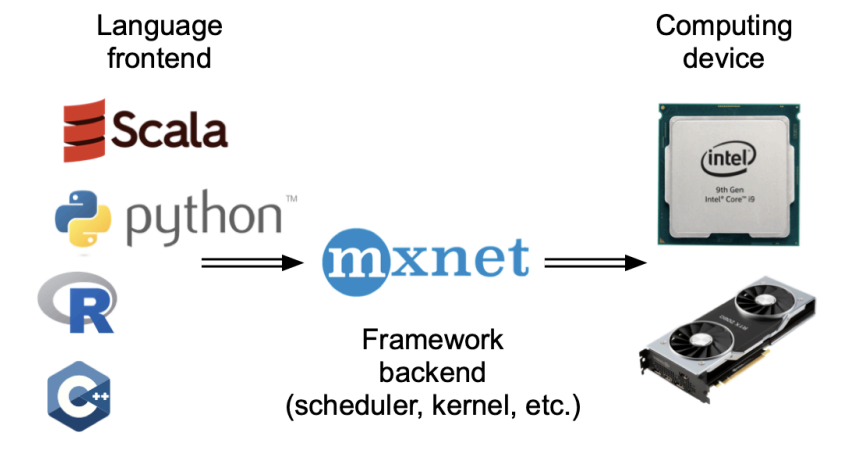

In [5]:
x = torch.ones((1, 2), device=device)
y = torch.ones((1, 2), device=device)
z = x * y + 2
z

tensor([[3., 3.]], device='cuda:0')

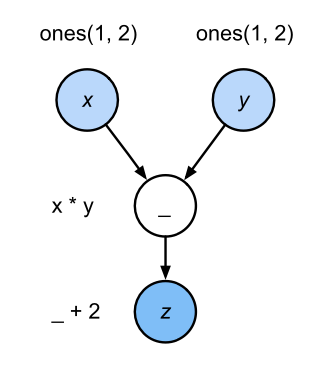

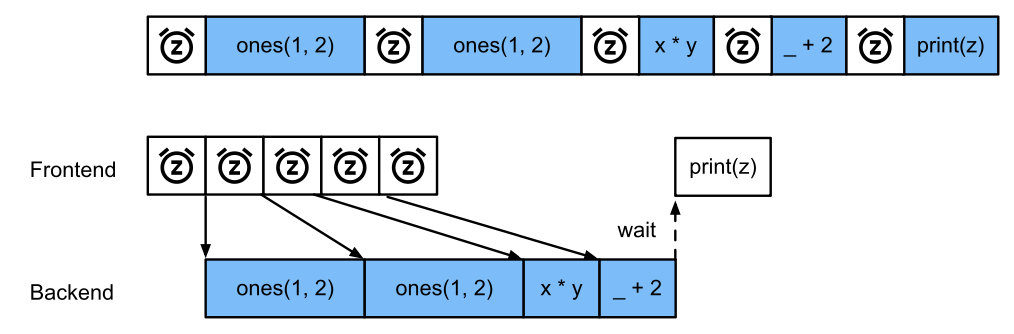